# method - 1 (full analytical solution first)

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

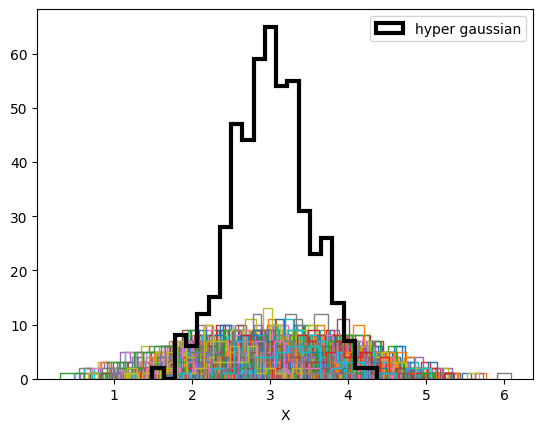

In [2]:
def generate_data(mean, scale, size):
    """
    Function to generate a Gaussian distribution with specified mean, scale and size. 
    """
    return np.random.normal(loc=mean, scale=scale, size=size)

# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = generate_data(true_parent_mean, true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

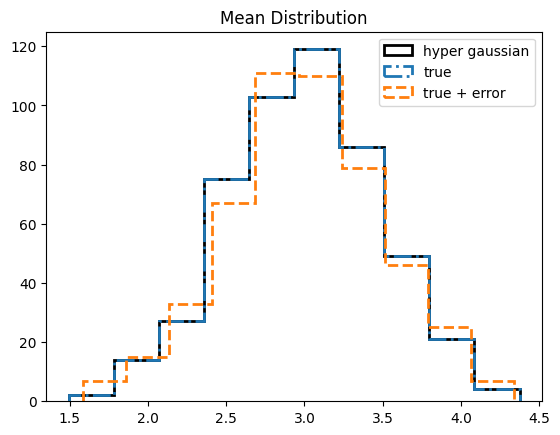

In [3]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [4]:
def log_likelihood(params):
    parent_mean, parent_scale = params

    weights = np.log(np.sum(
                (2 * np.pi * true_child_scale**2)**(-0.5) * \
                np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / \
                (2 * true_child_scale**2)),
                axis=1))
    chi_sq = ((child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2))
    
    return - 0.5 * N_obs * np.log(2 * np.pi * parent_scale**2 * size_child**2) - np.sum(chi_sq + weights)

In [5]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 3.006
sigma = 0.494


In [6]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 5):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [7]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:16<00:00, 117.92it/s]


State([[2.97785649 0.50767179]
 [3.01023308 0.52259483]
 [3.04141555 0.51120498]
 [3.01242074 0.50535666]
 [2.97740876 0.50264021]
 [2.99316031 0.52987094]
 [2.99264907 0.50184804]
 [2.98287316 0.4931567 ]
 [2.99904772 0.4878107 ]
 [3.01716744 0.49532787]
 [3.03010028 0.47683224]
 [3.03369018 0.49479366]
 [3.02225093 0.50360659]
 [2.99480503 0.51342938]
 [2.97518597 0.49678979]
 [3.00582693 0.46645397]
 [3.01078691 0.51796002]
 [2.9724741  0.48119185]
 [3.0676132  0.47590479]
 [2.98589736 0.49354962]
 [2.99771303 0.47614158]
 [2.99168993 0.4966272 ]
 [3.01753145 0.49556259]
 [2.96577824 0.49364683]
 [2.97132112 0.48509744]
 [3.03461967 0.49409276]
 [3.0144386  0.49906869]
 [2.97824226 0.48826999]
 [2.97727643 0.50358164]
 [2.98289951 0.47797744]
 [3.00893579 0.50715193]
 [3.04024649 0.5050448 ]
 [2.98652365 0.51417517]
 [3.0003938  0.48762467]
 [3.00806444 0.49981693]
 [2.98722166 0.50342693]
 [3.01703064 0.47869144]
 [3.00458644 0.49906727]
 [2.98941606 0.50331791]
 [2.98074816 0.4975

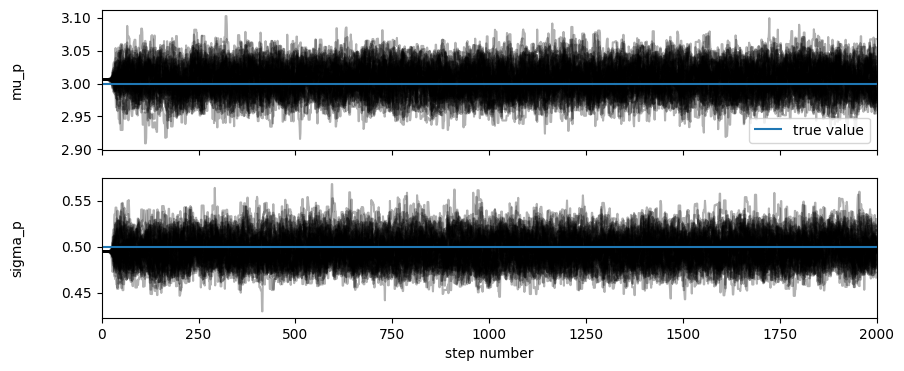

In [8]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[31.08575926 28.19024017]


In [10]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(6500, 2)


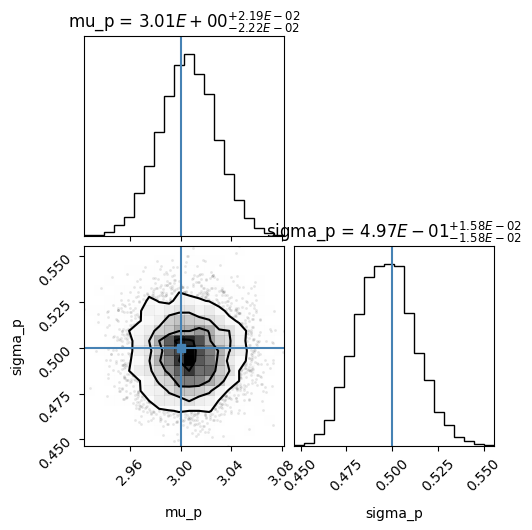

In [11]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

## method - 2 (generalized solution)

In [12]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

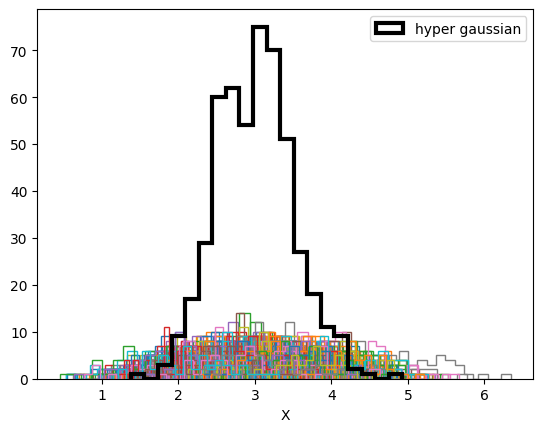

In [13]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)/10, axis=1)
child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

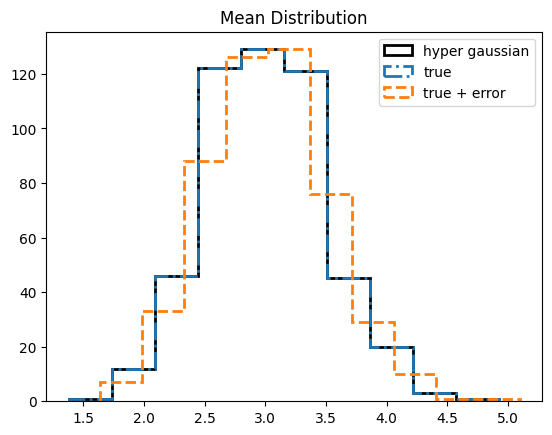

In [14]:
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=2, label='hyper gaussian')
plt.hist(parent_gaussian[:, np.newaxis], histtype='step', fill=False, label='true', linestyle='-.', linewidth=2)
plt.hist(parent_gaussian[:, np.newaxis] + err_on_mean_child, fill=False, histtype='step', label='true + error', linestyle='--', linewidth=2)
plt.title("Mean Distribution")
plt.legend()

In [15]:
posterior_child = lambda : (2 * np.pi * true_child_scale**2)**(-0.5) * np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / (2 * true_child_scale**2))
model = lambda parent_mean, parent_scale : (2 * np.pi * parent_scale**2)**(-0.5) * np.exp(-(child_gaussian.mean(axis=1) - parent_mean)**2 / (2 * parent_scale**2)) * \
                                            size_child**-1 * np.sum(posterior_child(), axis=1)

def log_likelihood(params):
    parent_mean, parent_scale = params
    return np.log(np.product(model(parent_mean, parent_scale)))

In [16]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 3.013
sigma = 0.501


/tmp/ipykernel_26422/3247082190.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale)))
/home/singh087/UofG/work/Code/HMtest/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_26422/3247082190.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(np.product(model(parent_mean, parent_scale)))


In [17]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [18]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 8000, progress=True)

100%|██████████| 8000/8000 [01:13<00:00, 108.35it/s]


State([[3.02051749 0.5043101 ]
 [2.98956822 0.5051    ]
 [2.98074685 0.50695102]
 [3.00013478 0.52019009]
 [2.98609483 0.49960984]
 [2.98197676 0.52428852]
 [2.99884363 0.50535578]
 [3.00443097 0.5195152 ]
 [3.00751734 0.51670799]
 [3.04625188 0.49325019]
 [3.00369963 0.50083587]
 [3.02294379 0.51660265]
 [3.03578823 0.53398377]
 [3.04476289 0.52874634]
 [3.0153969  0.49710603]
 [3.00544153 0.53725315]
 [2.99866608 0.51383733]
 [3.00750216 0.49670487]
 [3.00497342 0.48906877]
 [2.98097493 0.48068493]
 [3.01115459 0.4859719 ]
 [2.99814428 0.50454094]
 [2.99937925 0.50921589]
 [3.01006207 0.50548214]
 [3.01607882 0.52003283]
 [2.99330726 0.51803891]
 [3.01607086 0.485248  ]
 [3.00701764 0.48927409]
 [3.0053652  0.50094902]
 [3.01806419 0.52213092]
 [3.00449446 0.48839381]
 [3.00656452 0.51123608]
 [3.00965277 0.48173648]
 [3.042819   0.51258154]
 [3.01742031 0.51337495]
 [2.96528152 0.5171512 ]
 [2.98709428 0.52244125]
 [3.04583131 0.52725085]
 [3.01285368 0.52092548]
 [3.01247426 0.4771

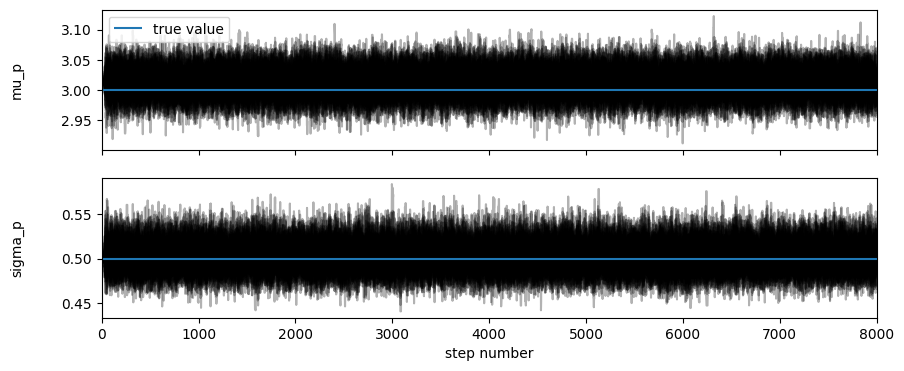

In [19]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [20]:
tau = sampler.get_autocorr_time()
print(tau)

[31.17864383 31.28798031]


In [21]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(26500, 2)


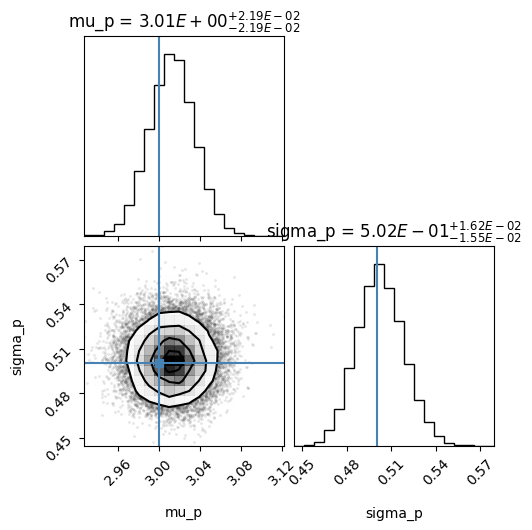

In [22]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)